# Fine-tuning a Multimodal Model for Healthcare

Note: please ignore all "_WandbInit._pause_backend()" warning errors. These are due to the remote VM used for training but have no consequences on model training and loading.

In [1]:
#!pip install --upgrade transformers
#!pip install --upgrade bitsandbytes
#!pip install --upgrade accelerate

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 47.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 14 19:40:24 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   54C    P8    24W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Part I - Data Loading

### A. EDA

In [4]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/path-vqa")

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [5]:
train_data = dataset['train']
test_data = dataset['test']

In [6]:
import matplotlib.pyplot as plt
import random

def plot_images_with_Q_and_A(num_images, dataset, columns=2):

  total_images = len(dataset)
  indices = random.sample(range(total_images), num_images)

  rows = (num_images + columns - 1) // columns
  fig, axes = plt.subplots(rows, columns, figsize=(15, 5*rows))

  for ax, index in zip(axes.flat, indices):
    item = dataset[index]
    image = item['image']
    question = item['question']
    answer = item['answer']
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Q: {question}\nA: {answer}", fontsize=12)

  for ax in axes.flat[num_images:]:
    ax.axis('off')

  plt.tight_layout()
  plt.show()

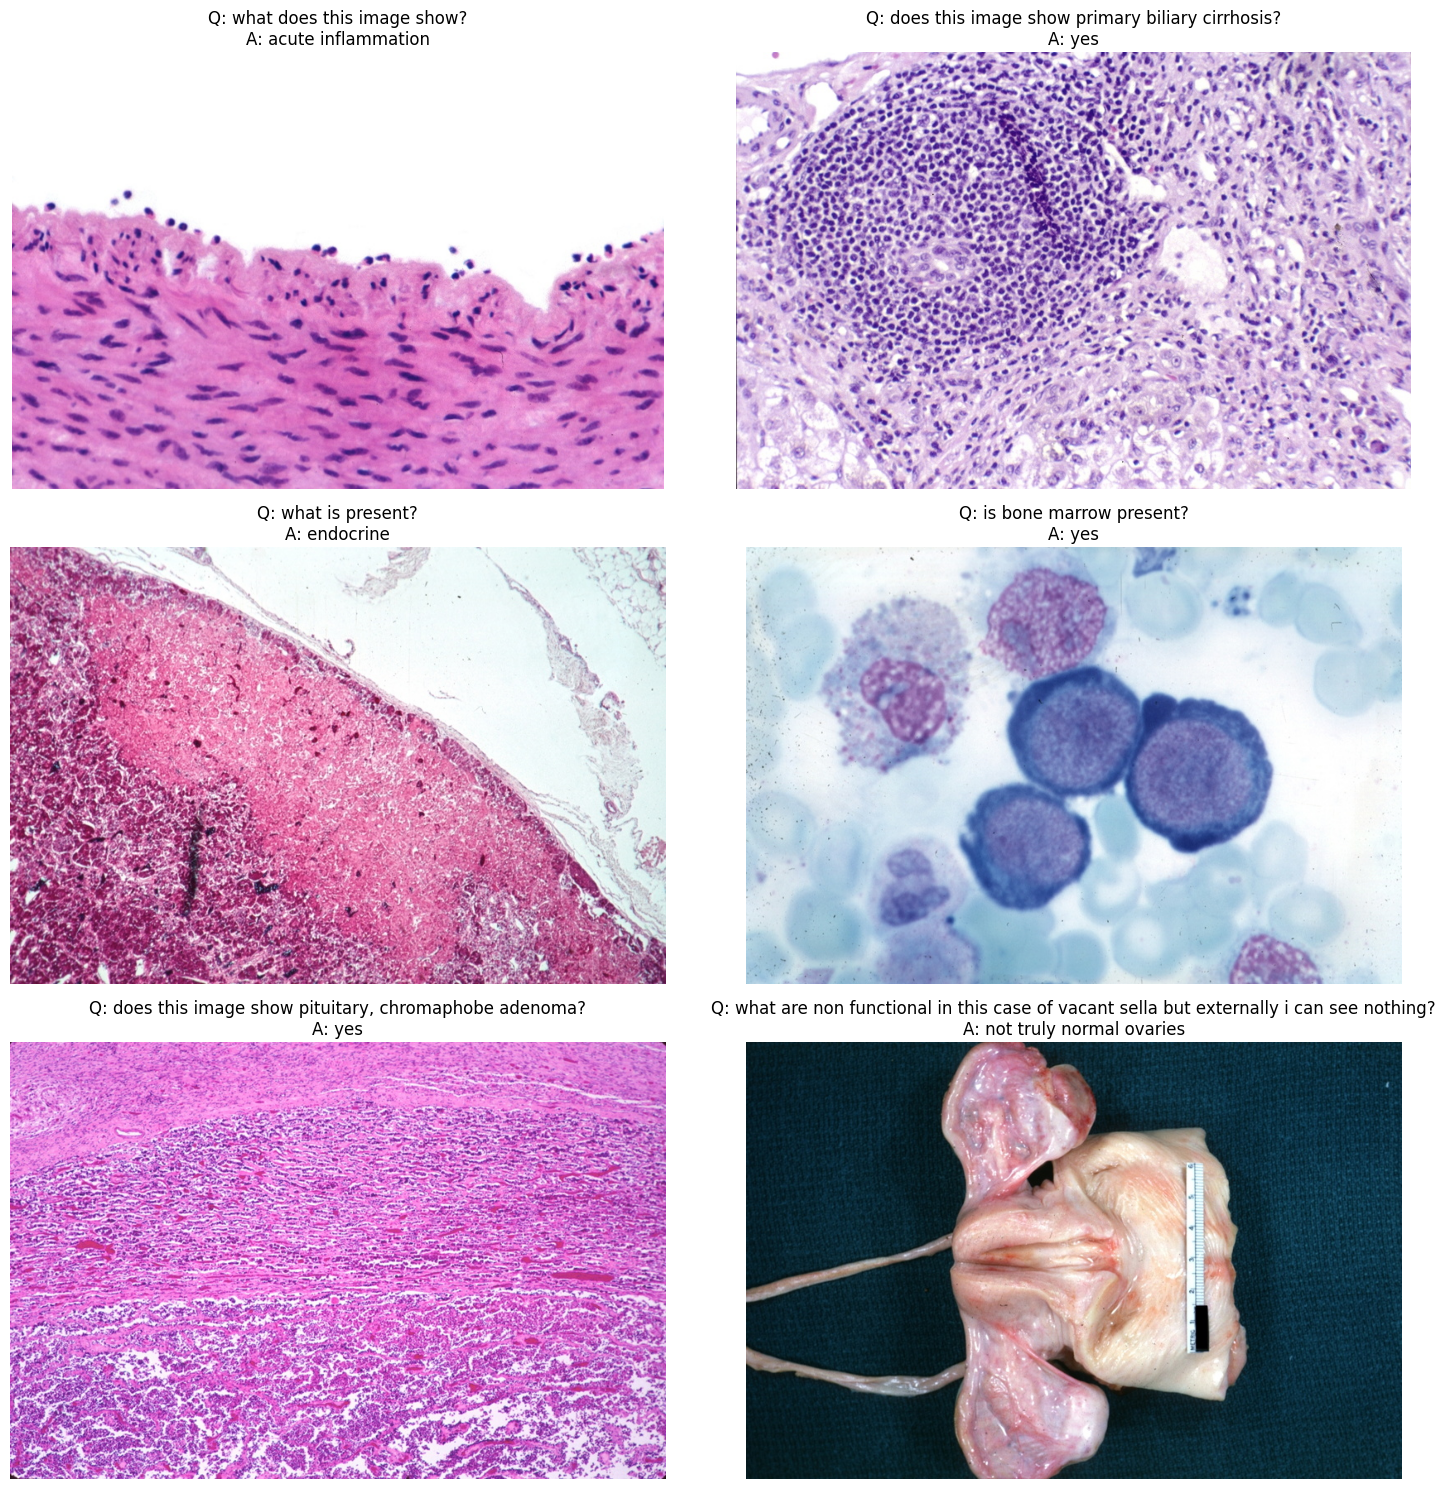

In [7]:
plot_images_with_Q_and_A(num_images=6, dataset=train_data, columns=2)

### B. Data Preprocessing

In [8]:
import torch
print(torch.cuda.is_available())

True


In [9]:
if torch.cuda.is_available():
    print("GPUs available:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Usage: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB")
else:
    print("No GPUs available.")

GPUs available:
GPU 0: NVIDIA RTX A6000
Memory Usage: 0.00 MB / 48676.75 MB


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In the below function, we will cast the questions from the dataset into prompts as expected by the model:

In [11]:
from transformers import AutoProcessor, AutoTokenizer
from PIL import Image

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
tokenizer = AutoTokenizer.from_pretrained("llava-hf/llava-1.5-7b-hf")

max_length = 512

def preprocess_function(examples):
    inputs = [f"USER: <image>\n{question}\nASSISTANT:" for question in examples['question']]
    images = examples['image']

    # Ensure all images are resized to the same size
    images = [image.resize((224, 224)) if isinstance(image, Image.Image) else Image.open(image).resize((224, 224)) for image in images]

    processor_inputs = processor(images=images, text=inputs, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    labels = tokenizer(examples['answer'], padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").input_ids

    processor_inputs["labels"] = labels
    return processor_inputs


2024-07-14 19:40:32.329287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 19:40:32.329387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 19:40:32.330520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 19:40:32.337273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 19:40:33.287323: W tensorflow/compiler/tf2

## Part II - Modeling

Due to limited computation power, we will train our model on only 1200 samples.

In [12]:
train_data_subset = train_data.select(range(1200))
train_dataset = train_data_subset.map(preprocess_function, batched=True, remove_columns=train_data_subset.column_names)

test_data_subset = test_data.select(range(200))
test_dataset = test_data_subset.map(preprocess_function, batched=True, remove_columns=test_data_subset.column_names)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

### A. Training Arguments

In [13]:
from transformers import AutoModelForPreTraining, BitsAndBytesConfig, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from peft import get_peft_model, LoraConfig, TaskType

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
model = AutoModelForPreTraining.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=quantization_config)

/usr/local/lib/python3.11/dist-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"]
)

peft_model = get_peft_model(model, peft_config)

In [15]:
data_collator = DataCollatorForLanguageModeling(tokenizer=processor.tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    gradient_accumulation_steps=1,
    fp16=True,
    remove_unused_columns=False,
)


trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.tokenizer
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### B. Training

In [16]:
torch.cuda.empty_cache()

trainer.train()

[2024-07-14 19:41:12,029] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: jules-guyet (jules-guyet-epita). Use `wandb login --relogin` to force relogin


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=3000, training_loss=0.7764656939109167, metrics={'train_runtime': 6160.7562, 'train_samples_per_second': 0.974, 'train_steps_per_second': 0.487, 'total_flos': 1.27807348801536e+17, 'train_loss': 0.7764656939109167, 'epoch': 5.0})

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f0fb5da3f90, execution_count=16 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f0fb5da3f10, raw_cell="torch.cuda.empty_cache()

trainer.train()" store_history=True silent=False shell_futures=True cell_id=ea97a1e9-8db4-4fa3-b70e-2cde6a263185> result=TrainOutput(global_step=3000, training_loss=0.7764656939109167, metrics={'train_runtime': 6160.7562, 'train_samples_per_second': 0.974, 'train_steps_per_second': 0.487, 'total_flos': 1.27807348801536e+17, 'train_loss': 0.7764656939109167, 'epoch': 5.0})>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

We save the model so we can load it during inference:

In [17]:
output_dir = "./fine_tuned_model"

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
trainer.model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f0fac6bfa10, raw_cell="output_dir = "./fine_tuned_model"

import os
if no.." store_history=True silent=False shell_futures=True cell_id=9747d96b-d908-45f6-96cf-6ba0b28dee27>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

['./fine_tuned_model/processor_config.json']

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f0e12193850, execution_count=17 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f0fac6bfa10, raw_cell="output_dir = "./fine_tuned_model"

import os
if no.." store_history=True silent=False shell_futures=True cell_id=9747d96b-d908-45f6-96cf-6ba0b28dee27> result=['./fine_tuned_model/processor_config.json']>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [20]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaForConditionalGeneration
import torch

saved_model_path = "./fine_tuned_model"


processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)

fine_tuned_model = LlavaForConditionalGeneration.from_pretrained(
    saved_model_path,
    torch_dtype=torch.float16,
    quantization_config=quantization_config)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f1047cc6150, raw_cell="from transformers import AutoProcessor, BitsAndByt.." store_history=True silent=False shell_futures=True cell_id=2a3e354e-9b9d-48a4-91ab-544cb4a53435>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f0de881f490, execution_count=20 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f1047cc6150, raw_cell="from transformers import AutoProcessor, BitsAndByt.." store_history=True silent=False shell_futures=True cell_id=2a3e354e-9b9d-48a4-91ab-544cb4a53435> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [21]:
import numpy as np

indices = np.random.choice(len(test_data), size=5, replace=False)
dash_line = "-" * 50
star_line = "*" * 50

for index in indices:
    print(dash_line)
    print(f"Example from row {index}")
    item = test_data[int(index)]
    image = item['image']
    question = item['question']
    answer = item['answer']
    prompt = f"USER: <image>\n{question}\nASSISTANT:"
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    base_generate_ids = model.generate(**inputs, max_new_tokens=100)
    base_answer = processor.batch_decode(base_generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    peft_generate_ids = fine_tuned_model.generate(**inputs, max_new_tokens=100)
    peft_answer = processor.batch_decode(peft_generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    print(star_line)
    print(question)
    print(f"Answer from base LLAVA: {base_answer[len(question):]}")
    print(dash_line)
    print(f"Answer from fine-tuned LLAVA: {peft_answer[len(question):]}")
    print(dash_line)
    print(f"Correct Answer from test_data: {answer}")
    print(star_line)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f0fac745d90, raw_cell="import numpy as np

indices = np.random.choice(len.." store_history=True silent=False shell_futures=True cell_id=4641946d-27ca-48ca-9897-c037a7aacf91>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

--------------------------------------------------
Example from row 5353
**************************************************
where is this?
Answer from base LLAVA: is this?
ASSISTANT: Mouth
--------------------------------------------------
Answer from fine-tuned LLAVA: is this?
ASSISTANT: Mouth
--------------------------------------------------
Correct Answer from test_data: oral
**************************************************
--------------------------------------------------
Example from row 1722
**************************************************
what is present?
Answer from base LLAVA: present?
ASSISTANT: Nonneoplastic gastric mucosa is characterized by a dense, tightly packed arrangement of cells, which is a characteristic feature of this lesion.
--------------------------------------------------
Answer from fine-tuned LLAVA: present?
ASSISTANT: Tumor, gastrointestinal stromal tumors, stromal tumors, gastrointestinal stromal tumor, stromal tumor, gastrointestinal stromal tumors,

TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

As we can see, the model is very verbose and it is hard to know if our answers are correct. Even if sometimes the model is totally wrong, often enough it seems the model is phrasing correct answers in a different way than the provided answer. Let's try to evaluate our model by computing accuracy using ROUGE score.

### C. Model Evaluation

In [38]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_threshold = 0.5

test_samples = test_data[-100:]

correct_predictions = 0
total_predictions = len(test_samples)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f0d31874c90, raw_cell="from rouge_score import rouge_scorer

scorer = rou.." store_history=True silent=False shell_futures=True cell_id=418388c4-efaa-4179-a04c-bafc502691d7>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f0cd8531dd0, execution_count=38 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f0d31874c90, raw_cell="from rouge_score import rouge_scorer

scorer = rou.." store_history=True silent=False shell_futures=True cell_id=418388c4-efaa-4179-a04c-bafc502691d7> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [42]:
for i in range(len(test_samples)):
    image = test_samples['image'][i]
    question = test_samples['question'][i]
    correct_answer = test_samples['answer'][i]
    prompt = f"USER: <image>\n{question}\nASSISTANT:"
    
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = fine_tuned_model.generate(**inputs, max_new_tokens=200)

    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    scores = scorer.score(correct_answer, generated_text)
    rougeL_score = scores['rougeL'].fmeasure

    if 'yes' in correct_answer.lower() or 'no' in correct_answer.lower():
        if 'yes' in generated_text.lower() or 'no' in generated_text.lower():
            is_correct = True
        else:
            is_correct = rougeL_score > rouge_threshold
    else:
        is_correct = rougeL_score > rouge_threshold

    if is_correct:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f12ff808bd0, raw_cell="for i in range(len(test_samples)):
    image = tes.." store_history=True silent=False shell_futures=True cell_id=910cd9ab-d50b-4819-a177-04a22123e0db>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Accuracy: 33.33%
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f12ff728c90, execution_count=42 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f12ff808bd0, raw_cell="for i in range(len(test_samples)):
    image = tes.." store_history=True silent=False shell_futures=True cell_id=910cd9ab-d50b-4819-a177-04a22123e0db> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [43]:
rouge_threshold = 0.3

for i in range(len(test_samples)):
    image = test_samples['image'][i]
    question = test_samples['question'][i]
    correct_answer = test_samples['answer'][i]
    prompt = f"USER: <image>\n{question}\nASSISTANT:"
    
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = fine_tuned_model.generate(**inputs, max_new_tokens=200)

    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    scores = scorer.score(correct_answer, generated_text)
    rougeL_score = scores['rougeL'].fmeasure

    if 'yes' in correct_answer.lower() or 'no' in correct_answer.lower():
        if 'yes' in generated_text.lower() or 'no' in generated_text.lower():
            is_correct = True
        else:
            is_correct = rougeL_score > rouge_threshold
    else:
        is_correct = rougeL_score > rouge_threshold

    if is_correct:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f0e122e61d0, raw_cell="rouge_threshold = 0.3

for i in range(len(test_sam.." store_history=True silent=False shell_futures=True cell_id=d26437c0-db67-4228-ad47-895da78b7a20>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

Accuracy: 66.67%
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f0fb5828b50>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f12ffa9e910, execution_count=43 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f0e122e61d0, raw_cell="rouge_threshold = 0.3

for i in range(len(test_sam.." store_history=True silent=False shell_futures=True cell_id=d26437c0-db67-4228-ad47-895da78b7a20> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

As we can see, changing the rouge threshold drastically impact our model accuracy. This makes sense as we are relying on the ROUGE-L which compares the two sentences and compute their similarity. However, it is still based on the number of n-grams (words) in commun. However, in a medical context, it is difficult to evaluate in such a simple way the performance of a model.